# PINN Learning of Burgers' Equation

\begin{equation}
    u_t + \lambda u u_x = \eta u_{xx}
\end{equation}

Using data provided alongside the original PINN paper (see README) with $\lambda = 1$ and $\eta = 0.01 / \pi$

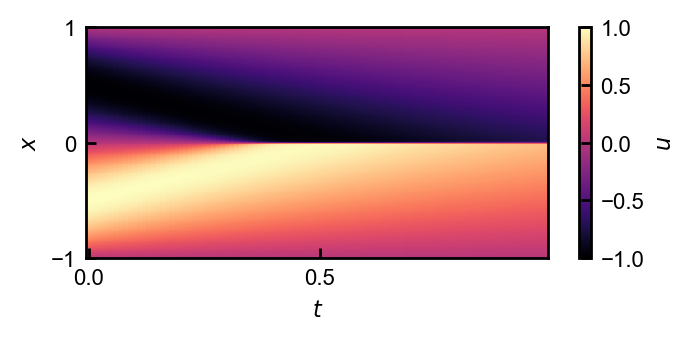

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, '../src')

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

plt.style.use('../../figure_style.mplstyle')

# Load data
data = loadmat('../data/burgers_shock.mat')
U_star = data['usol']
t_star = data['t']
x_star = data['x']

N = x_star.shape[0]
T = t_star.shape[0]

dt = t_star[1,0] - t_star[0,0]
dx = x_star[1,0] - x_star[0,0]

# Reshape data
XX = np.tile(x_star[:,0:1], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

x = XX.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1
u = U_star.flatten()[:,None] # NT x 1

# Plot data
def plot_field(ax, u, vmin, vmax, label=None):
    im = ax.pcolormesh(TT, XX, u, cmap='magma', vmin=vmin, vmax=vmax)
    ax.set(xlabel='$t$', xticks=[0, 0.5],
           ylabel='$x$', ylim=[-1,1], yticks=[-1, 0, 1],
           aspect=0.25)
    plt.colorbar(im, ax=ax, label=label)

fig, ax = plt.subplots(1,1, figsize=(4,1.5))
plot_field(ax, U_star, vmin=-1, vmax=1, label='$u$')

## Solve a Boundary Value Problem

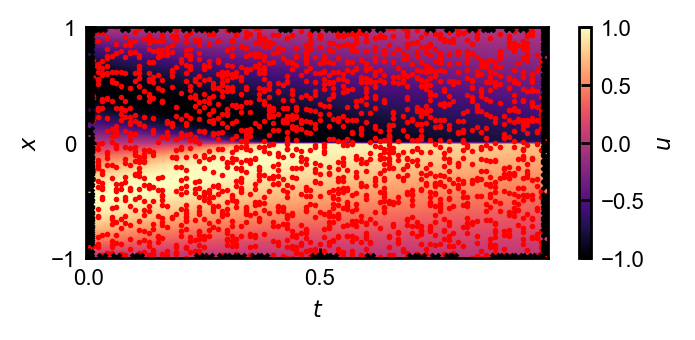

In [2]:
# Select points for bulk physics-informed loss
N_f = 2000
idx = np.random.choice(N*T, N_f, replace=False)
x_f, t_f, u_f = x[idx,:], t[idx,:], u[idx,:]

# Select boundary points for reconstruction loss
N_b = 200
idx = np.argwhere(np.logical_or(
    np.logical_or(x == x.min(), x == x.max()),
    np.logical_or(t == t.min(), t == t.max())
))[:,0]
idx = np.random.choice(idx, N_b, replace=False)
x_b, t_b, u_b = x[idx,:], t[idx,:], u[idx,:]

fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
plot_field(ax, U_star, vmin=-1, vmax=1, label='$u$')
ax.scatter(t_f, x_f, c='red', s=1)
ax.scatter(t_b, x_b, c='black', marker='x', s=10)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from pinn import PINN

class BurgersBVPPINN(PINN):
    def __init__(self, data: dict, log_dir: str):
        super().__init__(
            data=data,
            layers=[2, 50, 50, 50, 50, 1],
            num_params=0,
            log_dir=log_dir
        )

    def parse_data(self, data):
        self.x_f = nn.Parameter(torch.FloatTensor(data['x_f']), requires_grad=True)
        self.t_f = nn.Parameter(torch.FloatTensor(data['t_f']), requires_grad=True)
        self.u_f = nn.Parameter(torch.FloatTensor(data['u_f']), requires_grad=True)
        self.x_b = nn.Parameter(torch.FloatTensor(data['x_b']), requires_grad=True)
        self.t_b = nn.Parameter(torch.FloatTensor(data['t_b']), requires_grad=True)
        self.u_b = nn.Parameter(torch.FloatTensor(data['u_b']), requires_grad=True)

        X = torch.cat([self.x_f, self.t_f], dim=1)
        self.lb = nn.Parameter(X.min(0)[0], requires_grad=False)
        self.ub = nn.Parameter(X.max(0)[0], requires_grad=False)

    def predict_with_loss(self):
        u_b = self.forward(torch.cat([self.x_b, self.t_b], dim=-1))
        mse_loss = (u_b - self.u_b).pow(2).mean()

        u_f = self.forward(torch.cat([self.x_f, self.t_f], dim=-1))

        x = self.x_f
        t = self.t_f

        u_t = torch.autograd.grad(u_f.sum(), t, create_graph=True)[0]
        u_x = torch.autograd.grad(u_f.sum(), x, create_graph=True, retain_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

        eq = u_t + 1. * u_f * u_x - 0.01 / np.pi * u_xx
        phys_loss = eq.pow(2).mean()

        return u_f, mse_loss, phys_loss
    
if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model = BurgersBVPPINN(
    data=dict(
        x_f=x_f,
        t_f=t_f,
        u_f=u_f,
        x_b=x_b,
        t_b=t_b,
        u_b=u_b
    ),
    log_dir="./tb_logs/Burgers/BVP"
).to(device)
model.train(1)

Iteration 1000, Loss: 2.14832e-03, MSE: 8.85402e-04, Phys: 1.26292e-03
Iteration 2000, Loss: 9.52675e-04, MSE: 3.94912e-04, Phys: 5.57763e-04
Iteration 3000, Loss: 7.50612e-04, MSE: 3.25984e-04, Phys: 4.24628e-04
Iteration 4000, Loss: 5.03797e-04, MSE: 2.36690e-04, Phys: 2.67107e-04
Iteration 5000, Loss: 3.10629e-04, MSE: 1.74264e-04, Phys: 1.36365e-04
Iteration 6000, Loss: 2.06457e-04, MSE: 1.24788e-04, Phys: 8.16695e-05
Iteration 7000, Loss: 1.37773e-04, MSE: 8.28424e-05, Phys: 5.49305e-05
Iteration 8000, Loss: 9.42690e-05, MSE: 5.16249e-05, Phys: 4.26441e-05
Iteration 9000, Loss: 6.65717e-05, MSE: 4.06005e-05, Phys: 2.59712e-05
Iteration 10000, Loss: 5.13617e-05, MSE: 3.55948e-05, Phys: 1.57669e-05
Iteration 11000, Loss: 4.57302e-05, MSE: 3.36309e-05, Phys: 1.20993e-05
Iteration 12000, Loss: 4.18058e-05, MSE: 3.19730e-05, Phys: 9.83279e-06
Iteration 13000, Loss: 3.77198e-05, MSE: 2.97352e-05, Phys: 7.98455e-06


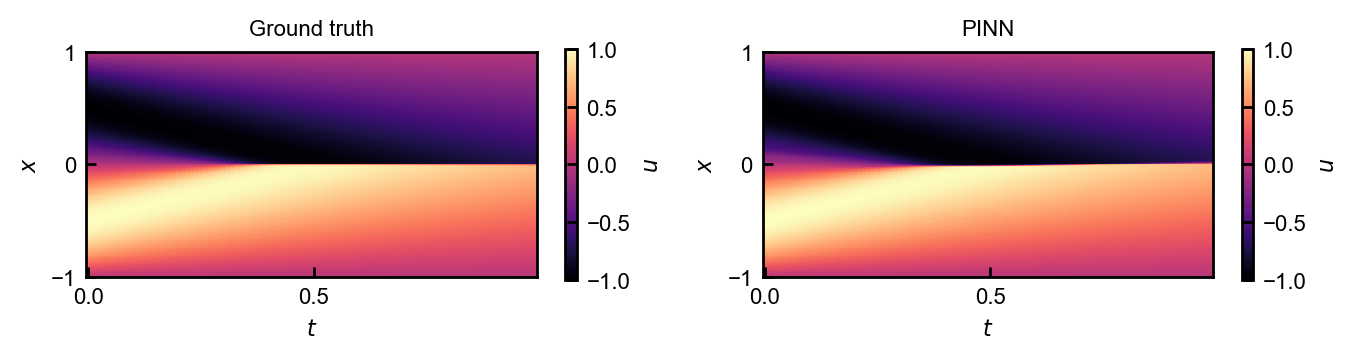

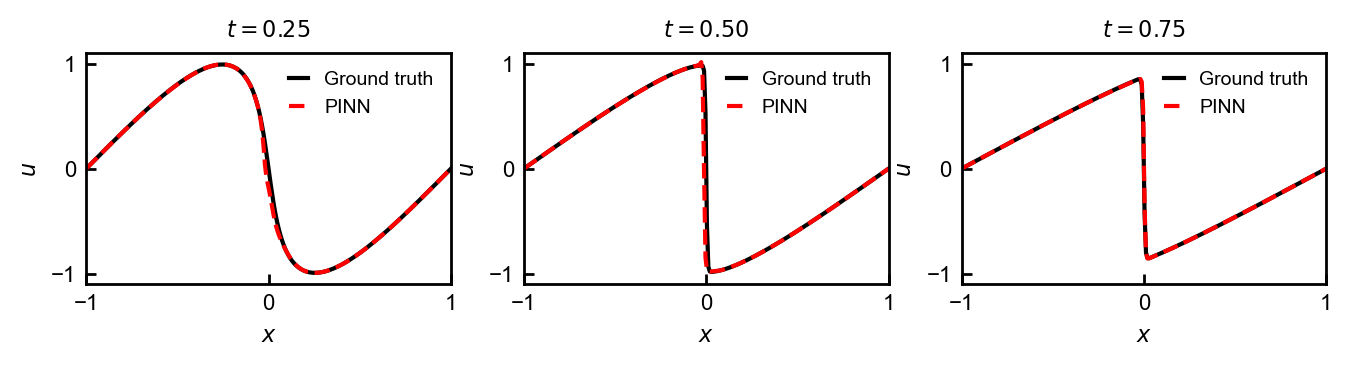

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(8, 1.5))

plot_field(ax[0], U_star, vmin=-1, vmax=1, label='$u$')
ax[0].set_title('Ground truth')

xt = torch.FloatTensor(np.stack([x, t], axis=-1)).to(device)
U_pred = model(xt).detach().cpu().numpy()
U_pred = U_pred.reshape(U_star.shape)
plot_field(ax[1], U_pred, vmin=-1, vmax=1, label='$u$')
ax[1].set_title('PINN')

fig, ax = plt.subplots(1, 3, figsize=(8, 1.5))

ax[0].plot(x_star, U_star[:,25], color='black', label='Ground truth')
ax[1].plot(x_star, U_star[:,50], color='black', label='Ground truth')
ax[2].plot(x_star, U_star[:,75], color='black', label='Ground truth')

ax[0].plot(x_star, U_pred[:,25], color='red', linestyle='--', label='PINN')
ax[1].plot(x_star, U_pred[:,50], color='red', linestyle='--', label='PINN')
ax[2].plot(x_star, U_pred[:,75], color='red', linestyle='--', label='PINN')

ax[0].set_title(f'$t = {t_star[25,0]:.2f}$')
ax[1].set_title(f'$t = {t_star[50,0]:.2f}$')
ax[2].set_title(f'$t = {t_star[75,0]:.2f}$')

for a in ax:
    a.set(xlabel='$x$', xlim=[-1, 1], xticks=[-1, 0, 1], 
          ylabel='$u$', ylim=[-1.1, 1.1], yticks=[-1, 0, 1])
    a.legend()

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from pinn import PINN

class BurgersParameterPINN(PINN):
    def __init__(self, data: dict, log_dir: str):
        super().__init__(
            data=data,
            layers=[2, 50, 50, 50, 50, 1],
            num_params=2,
            log_dir=log_dir
        )

    def parse_data(self, data):
        self.x_f = nn.Parameter(torch.FloatTensor(data['x_f']), requires_grad=True)
        self.t_f = nn.Parameter(torch.FloatTensor(data['t_f']), requires_grad=True)
        self.u_f = nn.Parameter(torch.FloatTensor(data['u_f']), requires_grad=True)

        X = torch.cat([self.x_f, self.t_f], dim=1)
        self.lb = nn.Parameter(X.min(0)[0], requires_grad=False)
        self.ub = nn.Parameter(X.max(0)[0], requires_grad=False)

    def log_tensorboard(self, loss, mse, phys):
        super().log_tensorboard(loss, mse, phys)
        self.writer.add_scalar('lambda', self.params[0].detach().item(), self.iter)
        self.writer.add_scalar('eta', self.params[1].exp().detach().item(), self.iter)

    def predict_with_loss(self):
        u_f = self.forward(torch.cat([self.x_f, self.t_f], dim=-1))
        mse_loss = (u_f - self.u_f).pow(2).mean()

        x = self.x_f
        t = self.t_f

        u_t = torch.autograd.grad(u_f.sum(), t, create_graph=True)[0]
        u_x = torch.autograd.grad(u_f.sum(), x, create_graph=True, retain_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

        lambda_1 = self.params[0]
        eta = self.params[1].exp()
        eq = u_t + lambda_1 * u_f * u_x - eta * u_xx
        phys_loss = eq.pow(2).mean()

        return u_f, mse_loss, phys_loss
    
if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model = BurgersParameterPINN(
    data=dict(
        x_f=x_f,
        t_f=t_f,
        u_f=u_f,
    ),
    log_dir="./tb_logs/Burgers/Parameter"
).to(device)
model.train(1)

Iteration 1000, Loss: 1.37706e-03, MSE: 8.85948e-04, Phys: 4.91115e-04
Iteration 2000, Loss: 2.64176e-04, MSE: 1.38366e-04, Phys: 1.25809e-04
Iteration 3000, Loss: 1.03908e-04, MSE: 5.05223e-05, Phys: 5.33860e-05
Iteration 4000, Loss: 6.10864e-05, MSE: 2.80810e-05, Phys: 3.30054e-05
Iteration 5000, Loss: 3.91943e-05, MSE: 1.47071e-05, Phys: 2.44873e-05


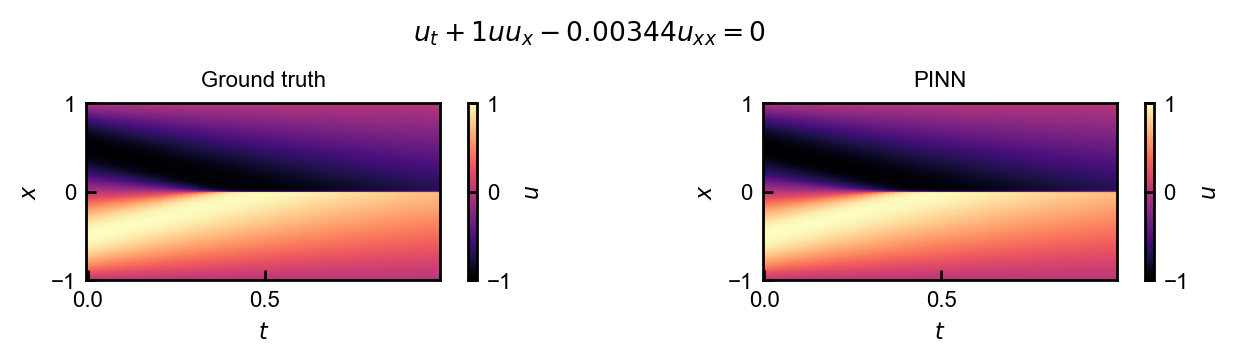

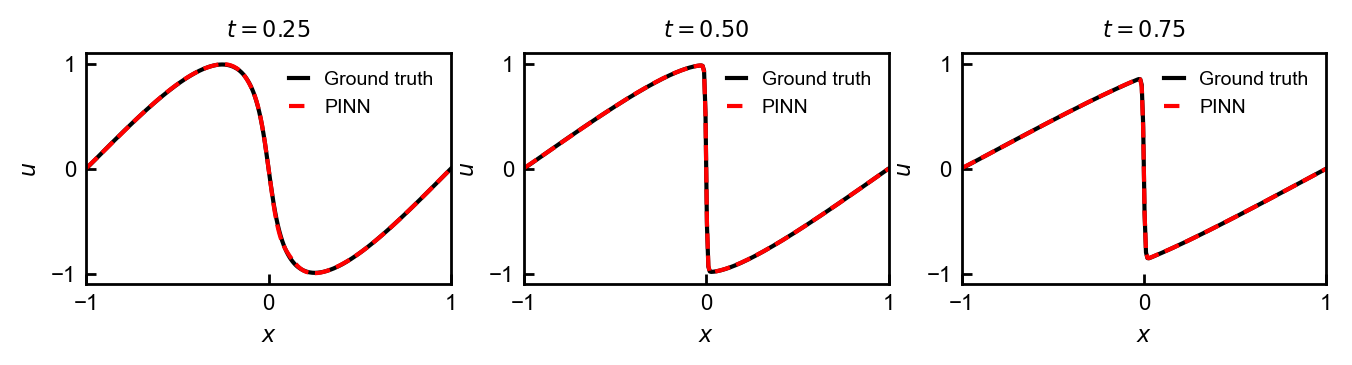

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(8, 1.5))

plot_field(ax[0], U_star, vmin=-1, vmax=1, label='$u$')
ax[0].set_title('Ground truth')

xt = torch.FloatTensor(np.stack([x, t], axis=-1)).to(device)
U_pred = model(xt).detach().cpu().numpy()
U_pred = U_pred.reshape(U_star.shape)
plot_field(ax[1], U_pred, vmin=-1, vmax=1, label='$u$')
ax[1].set_title('PINN')

fig.subplots_adjust(top=0.7)
fig.suptitle(f'$u_t + {model.params[0].detach().item():.3g} u u_x - {model.params[1].exp().detach().item():.3g} u_{{xx}} = 0$')

fig, ax = plt.subplots(1, 3, figsize=(8, 1.5))

ax[0].plot(x_star, U_star[:,25], color='black', label='Ground truth')
ax[1].plot(x_star, U_star[:,50], color='black', label='Ground truth')
ax[2].plot(x_star, U_star[:,75], color='black', label='Ground truth')

ax[0].plot(x_star, U_pred[:,25], color='red', linestyle='--', label='PINN')
ax[1].plot(x_star, U_pred[:,50], color='red', linestyle='--', label='PINN')
ax[2].plot(x_star, U_pred[:,75], color='red', linestyle='--', label='PINN')

ax[0].set_title(f'$t = {t_star[25,0]:.2f}$')
ax[1].set_title(f'$t = {t_star[50,0]:.2f}$')
ax[2].set_title(f'$t = {t_star[75,0]:.2f}$')

for a in ax:
    a.set(xlabel='$x$', xlim=[-1, 1], xticks=[-1, 0, 1], 
          ylabel='$u$', ylim=[-1.1, 1.1], yticks=[-1, 0, 1])
    a.legend()